In [ ]:
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
sys.path.append('script')
from script import dbconn
pgconn = dbconn.db_connection_psycopg()

In [ ]:
# Fectching data from the postgreSql database and put the value on raw_df
raw_df = dbconn.db_read_table_psycopg(pgconn,'xdr_data')

In [ ]:
raw_df.info

In [ ]:
raw_df.describe

In [ ]:
raw_df.columns

In [ ]:
#the top 10 handsets used by the customers
top_10_handsets = raw_df['Handset Type'].value_counts().head(10)
print(top_10_handsets)

In [ ]:
#the top 3 handset manufacturers
top_3_manufacturers = raw_df['Handset Manufacturer'].value_counts().head(3)
print(top_3_manufacturers)

In [ ]:
# the top 5 handsets per top 3 handset manufacturer
top_3_manufacturers = raw_df['Handset Manufacturer'].value_counts().head(3).index

for manufacturer in top_3_manufacturers:
    top_5_handsets = raw_df.loc[raw_df['Handset Manufacturer'] == manufacturer, 'Handset Type'].value_counts().head(5)
    print(f"Top 5 handsets for {manufacturer}:")
    print(top_5_handsets)
    print()

                                   TASK 2.1

In [ ]:
#number of xDR sessions
user_sessions = raw_df.groupby('MSISDN/Number')['Bearer Id'].count().reset_index()
user_sessions.columns = ['MSISDN/Number', 'Number of xDR Sessions']
print(user_sessions)

In [ ]:
#Session duration
user_session_duration = raw_df.groupby('MSISDN/Number')['Dur. (ms)'].sum().reset_index()
user_session_duration.columns = ['MSISDN/Number', 'Session Duration']
print(user_session_duration)

In [ ]:
#the total download (DL) and upload (UL) data
user_data = raw_df.groupby('MSISDN/Number').agg({
    'Total DL (Bytes)': 'sum',
    'Total UL (Bytes)': 'sum'
}).reset_index()
user_data.columns = ['MSISDN/Number', 'Total DL Data', 'Total UL Data']
print(user_data)

In [ ]:
#the total data volume (in Bytes) 
user_session_data = raw_df.groupby('MSISDN/Number').agg({
    'Total UL (Bytes)': 'sum',
    'Total DL (Bytes)': 'sum'
}).reset_index()
user_session_data['Total Data Volume'] = user_session_data['Total UL (Bytes)'] + user_session_data['Total DL (Bytes)']
user_session_data = user_session_data[['MSISDN/Number', 'Total Data Volume']]
print(user_session_data)

                                     TASK 2.2

In [ ]:
raw_df.info()

In [ ]:
raw_df.isna().sum()

In [ ]:
raw_df.describe

In [ ]:
#percent of missing data

def percent_missing(df):
    # Calculate total number of cells in dataframe
    totalCells = np.product(df.shape)

    # Count number of missing values per column
    missingCount = df.isnull().sum()

    # Calculate total number of missing values
    totalMissing = missingCount.sum()

    # Calculate percentage of missing values
    percentageMissing = (totalMissing / totalCells) * 100

    print("The dataset contains", round(percentageMissing, 2), "%", "missing values.")

percent_missing(raw_df)

In [ ]:
#Identify and replace outliers and missing values with column mean



# Replace missing values with column mean
raw_df.fillna(raw_df.mean(), inplace=True)

# Identify and replace outliers with column mean
num_columns = raw_df.select_dtypes(include=[np.number]).columns

for col in num_columns:
    z_scores = (raw_df[col] - raw_df[col].mean()) / raw_df[col].std()
    outliers = (z_scores > 3) | (z_scores < -3)
    raw_df[col][outliers] = raw_df[col].mean()

# Verify missing values and outliers have been treated
missing_values_after_treatment = raw_df.isnull().sum()
print("Missing Values After Treatment:\n", missing_values_after_treatment)

In [ ]:
# Calculate the percentage of missing values in each column
missing_percent = (raw_df.isnull().sum() / len(raw_df)) * 100

# Drop columns with more than 30% missing values
columns_to_drop = missing_percent[missing_percent > 30].index
df_clean = raw_df.drop(columns_to_drop, axis=1)

# Print the shape of the cleaned DataFrame
print("Shape of cleaned DataFrame:", df_clean.shape)

In [ ]:
missing_values = raw_df.isna().sum()
print(missing_values)

In [ ]:
#Solving The rest of missing values
def fix_missing_ffill(df, col):
    df[col] = df[col].fillna(method='ffill')
    return df[col]

raw_df['Start'] = fix_missing_ffill(raw_df, 'Start')
raw_df['End'] = fix_missing_ffill(raw_df, 'End')
raw_df['Last Location Name'] = fix_missing_ffill(raw_df, 'Last Location Name')

missing_values = raw_df.isna().sum()
print(missing_values)

In [ ]:

# Calculate basic metrics
metrics = raw_df.describe()
mean = metrics.loc['mean']
median = metrics.loc['50%']
mode = raw_df.mode().iloc[0]
minimum = metrics.loc['min']
maximum = metrics.loc['max']
std_deviation = metrics.loc['std']

# Print the basic metrics
print("Mean:\n", mean)
print("\nMedian:\n", median)
print("\nMode:\n", mode)
print("\nMinimum:\n", minimum)
print("\nMaximum:\n", maximum)
print("\nStandard Deviation:\n", std_deviation)


In [ ]:
#a Non-Graphical Univariate Analysis by computing dispersion parameters for each quantitative variable

# Select quantitative variables in the dataset
quantitative_vars = raw_df.select_dtypes(include=[np.number])

# Compute dispersion parameters for each quantitative variable
dispersion_parameters = quantitative_vars.agg(['mean', 'median', 'std', 'min', 'max', 'var'])

# Print the dispersion parameters
print("Dispersion Parameters:\n", dispersion_parameters)

In [ ]:
#a Graphical Univariate Analysis for each variable

# Select variables in the dataset
variables = raw_df.columns

# Plotting options for each variable
for variable in variables:
    if raw_df[variable].dtype == 'int64' or raw_df[variable].dtype == 'float64':
        # For numeric variables (continuous or discrete)
        plt.figure(figsize=(8, 6))
        sns.histplot(data=raw_df, x=variable, kde=True)
        plt.title(f'Distribution of {variable}')
        plt.xlabel(variable)
        plt.ylabel('Frequency')
        plt.show()
    else:
        # For categorical variables
        plt.figure(figsize=(8, 6))
        sns.countplot(data=raw_df, x=variable)
        plt.title(f'Count of {variable}')
        plt.xlabel(variable)
        plt.ylabel('Count')
        plt.xticks(rotation=90)
        plt.show()

In [ ]:
#Correlation Analysis
variables = ['Social Media DL (Bytes)', 'Google DL (Bytes)', 'Email DL (Bytes)',
             'Youtube DL (Bytes)', 'Netflix DL (Bytes)', 'Gaming DL (Bytes)',
             'Other DL (Bytes)']

# Subset the DataFrame with the selected variables
subset_df = raw_df[variables]

# Compute the correlation matrix
correlation_matrix = subset_df.corr()

# Print the correlation matrix
print("Correlation Matrix:")
print(correlation_matrix)

In [ ]:
#Dimensionality Reduction 

# Assuming you have a DataFrame 'raw_df' with the relevant variables
variables = ['Social Media DL (Bytes)', 'Google DL (Bytes)', 'Email DL (Bytes)',
             'Youtube DL (Bytes)', 'Netflix DL (Bytes)', 'Gaming DL (Bytes)',
             'Other DL (Bytes)']

# Subset the DataFrame with the selected variables
subset_df = raw_df[variables]

# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(subset_df)

# Perform PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_data)

# Create a DataFrame with the principal components
pc_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

# Explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Interpretation of the results
print("Interpretation of PCA results:")
print("- The first principal component (PC1) explains", round(explained_variance_ratio[0] * 100, 2), "% of the variance in the data.")
print("- The second principal component (PC2) explains", round(explained_variance_ratio[1] * 100, 2), "% of the variance in the data.")
print("- PC1 captures the most significant patterns and trends in the data, such as overall data usage level.")
print("- PC2 captures additional variation that is orthogonal to PC1 and represents specific usage patterns or differences between the applications.")

      Task 3 - User Engagement analysis

In [87]:
#top 10 customers per engagement metric 

# Engagement metrics
engagement_metrics = ['Social Media DL (Bytes)', 'Google DL (Bytes)', 'Email DL (Bytes)',
                      'Youtube DL (Bytes)', 'Netflix DL (Bytes)', 'Gaming DL (Bytes)',
                      'Other DL (Bytes)']

# Group by 'MSISDN/Number' and calculate the sum of each engagement metric
grouped_df = raw_df.groupby('MSISDN/Number')[engagement_metrics].sum()

# Calculate the total engagement metric for each customer
grouped_df['Total Engagement'] = grouped_df.sum(axis=1)

# Report the top 10 customers for each engagement metric
for metric in engagement_metrics:
    top_10_customers = grouped_df.nlargest(10, metric)
    print(f"Top 10 customers for {metric}:")
    print(top_10_customers)
    print()

Top 10 customers for Social Media DL (Bytes):
               Social Media DL (Bytes)  Google DL (Bytes)  Email DL (Bytes)  \
MSISDN/Number                                                                 
3.373303e+10              1.939712e+09       6.022143e+09      1.909556e+09   
3.362632e+10              4.274384e+07       1.161065e+08      3.340478e+07   
3.376054e+10              3.929765e+07       8.862653e+07      2.643790e+07   
3.365973e+10              3.490044e+07       9.095855e+07      2.990765e+07   
3.361489e+10              2.774974e+07       9.394171e+07      3.360721e+07   
3.362578e+10              2.656412e+07       1.079047e+08      3.189541e+07   
3.366716e+10              2.375375e+07       7.170783e+07      2.327675e+07   
3.378632e+10              2.356866e+07       7.881981e+07      3.087691e+07   
3.366907e+10              2.347705e+07       5.491522e+07      1.781358e+07   
3.360313e+10              2.277668e+07       7.394206e+07      2.034373e+07   

     

In [92]:
#Normalize each engagement metric and run a k-means (k=3) to classify customers in three groups of engagement. 
# Engagement metrics
engagement_metrics = ['Social Media DL (Bytes)', 'Google DL (Bytes)', 'Email DL (Bytes)',
                      'Youtube DL (Bytes)', 'Netflix DL (Bytes)', 'Gaming DL (Bytes)',
                      'Other DL (Bytes)']

# Select the engagement metrics from the DataFrame
engagement_data = raw_df[engagement_metrics]

# Normalize the engagement data using Min-Max scaling
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(engagement_data)

# Perform k-means clustering with k=3
kmeans = KMeans(n_clusters=3)
kmeans.fit(normalized_data)

# Assign the cluster labels to the original DataFrame
raw_df['Engagement Cluster'] = kmeans.labels_

# Print the number of customers in each engagement cluster
print(raw_df['Engagement Cluster'].value_counts())

# Alternatively, you can group the data by the engagement cluster and calculate statistics
cluster_stats = raw_df.groupby('Engagement Cluster')[engagement_metrics].mean()
print(cluster_stats)

C:\Users\dell\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


0    56542
2    46807
1    46652
Name: Engagement Cluster, dtype: int64
                    Social Media DL (Bytes)  Google DL (Bytes)  \
Engagement Cluster                                               
0                              1.804933e+06       5.721730e+06   
1                              1.815811e+06       5.794773e+06   
2                              1.763289e+06       5.741937e+06   

                    Email DL (Bytes)  Youtube DL (Bytes)  Netflix DL (Bytes)  \
Engagement Cluster                                                             
0                       1.814791e+06        1.165359e+07        4.559013e+06   
1                       2.741980e+06        1.173830e+07        1.604855e+07   
2                       8.167664e+05        1.150661e+07        1.575762e+07   

                    Gaming DL (Bytes)  Other DL (Bytes)  
Engagement Cluster                                       
0                        4.256474e+08      4.264908e+08  
1                     

C:\Users\dell\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


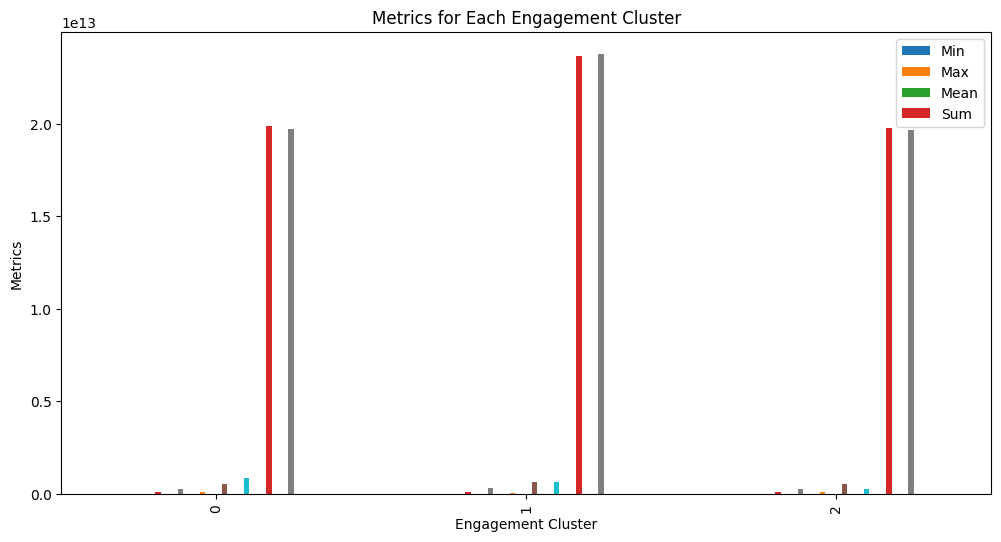

                   Social Media DL (Bytes)                           \
                                       min        max          mean   
Engagement Cluster                                                    
0                                    274.0  3585895.0  1.794968e+06   
1                                     12.0  3586043.0  1.781802e+06   
2                                     34.0  3586064.0  1.812046e+06   

                                 Google DL (Bytes)                            \
                             sum               min         max          mean   
Engagement Cluster                                                             
0                   8.494865e+10             301.0  11462832.0  5.821165e+06   
1                   1.001782e+11             207.0  11462752.0  5.759198e+06   
2                   8.417317e+10             297.0  11462553.0  5.668794e+06   

                                 Email DL (Bytes)             ...  \
                       

C:\Users\dell\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


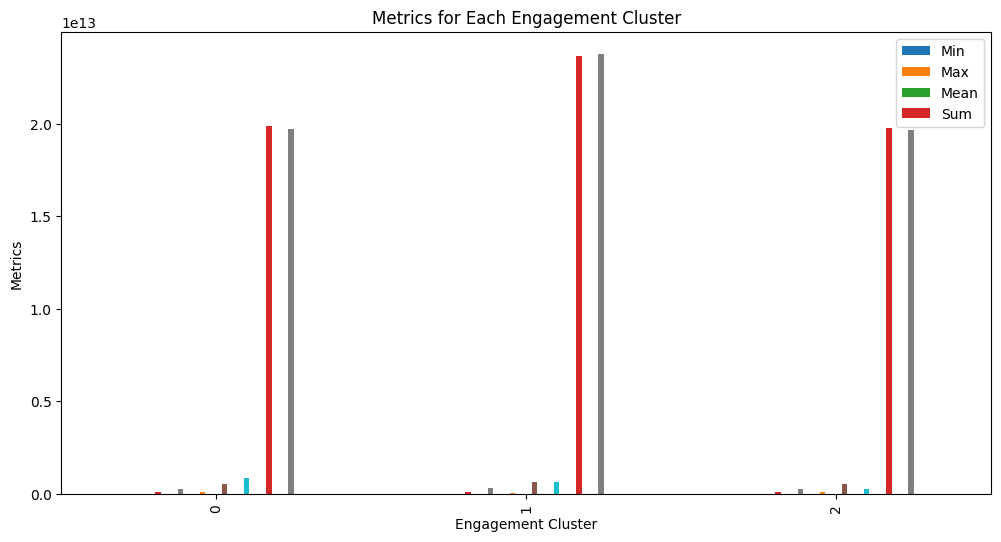

                   Social Media DL (Bytes)                           \
                                       min        max          mean   
Engagement Cluster                                                    
0                                    274.0  3585895.0  1.794968e+06   
1                                     12.0  3586043.0  1.781802e+06   
2                                     34.0  3586064.0  1.812046e+06   

                                 Google DL (Bytes)                            \
                             sum               min         max          mean   
Engagement Cluster                                                             
0                   8.494865e+10             301.0  11462832.0  5.821165e+06   
1                   1.001782e+11             207.0  11462752.0  5.759198e+06   
2                   8.417317e+10             297.0  11462553.0  5.668794e+06   

                                 Email DL (Bytes)             ...  \
                       

C:\Users\dell\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


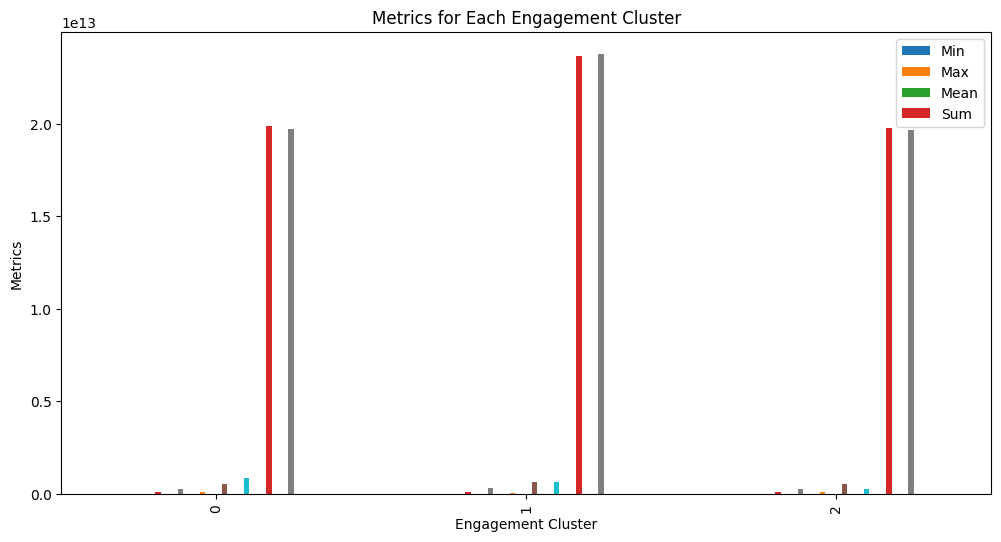

                   Social Media DL (Bytes)                           \
                                       min        max          mean   
Engagement Cluster                                                    
0                                    274.0  3585895.0  1.794968e+06   
1                                     12.0  3586043.0  1.781802e+06   
2                                     34.0  3586064.0  1.812046e+06   

                                 Google DL (Bytes)                            \
                             sum               min         max          mean   
Engagement Cluster                                                             
0                   8.494865e+10             301.0  11462832.0  5.821165e+06   
1                   1.001782e+11             207.0  11462752.0  5.759198e+06   
2                   8.417317e+10             297.0  11462553.0  5.668794e+06   

                                 Email DL (Bytes)             ...  \
                       

In [90]:
#the minimum, maximum, average & total non-normalized metrics for each cluster
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans


# Engagement metrics
engagement_metrics = ['Social Media DL (Bytes)', 'Google DL (Bytes)', 'Email DL (Bytes)',
                      'Youtube DL (Bytes)', 'Netflix DL (Bytes)', 'Gaming DL (Bytes)',
                      'Other DL (Bytes)']

# Select the engagement metrics from the DataFrame
engagement_data = raw_df[engagement_metrics]

# Normalize the engagement data using Min-Max scaling
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(engagement_data)

# Perform k-means clustering with k=3
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(normalized_data)

# Assign the cluster labels to the original DataFrame
raw_df['Engagement Cluster'] = kmeans.labels_

# Compute non-normalized metrics for each cluster
cluster_stats = raw_df.groupby('Engagement Cluster')[engagement_metrics].agg(['min', 'max', 'mean', 'sum'])

# Visualize the results
cluster_stats.plot(kind='bar', figsize=(12, 6))
plt.xlabel('Engagement Cluster')
plt.ylabel('Metrics')
plt.title('Metrics for Each Engagement Cluster')
plt.legend(['Min', 'Max', 'Mean', 'Sum'])
plt.show()

# Print the cluster statistics
print(cluster_stats)
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

# Assuming 'raw_df' is the DataFrame containing the metrics

# Engagement metrics
engagement_metrics = ['Social Media DL (Bytes)', 'Google DL (Bytes)', 'Email DL (Bytes)',
                      'Youtube DL (Bytes)', 'Netflix DL (Bytes)', 'Gaming DL (Bytes)',
                      'Other DL (Bytes)']

# Select the engagement metrics from the DataFrame
engagement_data = raw_df[engagement_metrics]

# Normalize the engagement data using Min-Max scaling
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(engagement_data)

# Perform k-means clustering with k=3
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(normalized_data)

# Assign the cluster labels to the original DataFrame
raw_df['Engagement Cluster'] = kmeans.labels_

# Compute non-normalized metrics for each cluster
cluster_stats = raw_df.groupby('Engagement Cluster')[engagement_metrics].agg(['min', 'max', 'mean', 'sum'])

# Visualize the results
cluster_stats.plot(kind='bar', figsize=(12, 6))
plt.xlabel('Engagement Cluster')
plt.ylabel('Metrics')
plt.title('Metrics for Each Engagement Cluster')
plt.legend(['Min', 'Max', 'Mean', 'Sum'])
plt.show()

# Print the cluster statistics
print(cluster_stats)

# Engagement metrics
engagement_metrics = ['Social Media DL (Bytes)', 'Google DL (Bytes)', 'Email DL (Bytes)',
                      'Youtube DL (Bytes)', 'Netflix DL (Bytes)', 'Gaming DL (Bytes)',
                      'Other DL (Bytes)']

# Select the engagement metrics from the DataFrame
engagement_data = raw_df[engagement_metrics]

# Normalize the engagement data using Min-Max scaling
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(engagement_data)

# Perform k-means clustering with k=3
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(normalized_data)

# Assign the cluster labels to the original DataFrame
raw_df['Engagement Cluster'] = kmeans.labels_

# Compute non-normalized metrics for each cluster
cluster_stats = raw_df.groupby('Engagement Cluster')[engagement_metrics].agg(['min', 'max', 'mean', 'sum'])

# Visualize the results
cluster_stats.plot(kind='bar', figsize=(12, 6))
plt.xlabel('Engagement Cluster')
plt.ylabel('Metrics')
plt.title('Metrics for Each Engagement Cluster')
plt.legend(['Min', 'Max', 'Mean', 'Sum'])
plt.show()

# Print the cluster statistics
print(cluster_stats)

In [93]:
#Aggregate user total traffic per application and derive the top 10 most engaged users per application


# Application columns
application_columns = ['Social Media DL (Bytes)', 'Google DL (Bytes)', 'Email DL (Bytes)',
                       'Youtube DL (Bytes)', 'Netflix DL (Bytes)', 'Gaming DL (Bytes)',
                       'Other DL (Bytes)']

# Calculate total traffic per application for each user
user_traffic = raw_df.groupby('MSISDN/Number')[application_columns].sum()

# Derive the top 10 most engaged users per application
top_10_users_per_app = pd.DataFrame()
for column in application_columns:
    top_10_users = user_traffic.nlargest(10, column)
    top_10_users_per_app[column] = top_10_users.index

# Print the top 10 most engaged users per application
print("Top 10 most engaged users per application:")
print(top_10_users_per_app)

Top 10 most engaged users per application:
   Social Media DL (Bytes)  Google DL (Bytes)  Email DL (Bytes)  \
0             3.373303e+10       3.373303e+10      3.373303e+10   
1             3.362632e+10       3.362632e+10      3.361489e+10   
2             3.376054e+10       3.362578e+10      3.362632e+10   
3             3.365973e+10       3.361489e+10      3.362578e+10   
4             3.361489e+10       3.365973e+10      3.378632e+10   
5             3.362578e+10       3.376054e+10      3.365973e+10   
6             3.366716e+10       3.367588e+10      3.376054e+10   
7             3.378632e+10       3.378632e+10      3.366546e+10   
8             3.366907e+10       3.360313e+10      3.367588e+10   
9             3.360313e+10       3.376127e+10      3.369879e+10   

   Youtube DL (Bytes)  Netflix DL (Bytes)  Gaming DL (Bytes)  Other DL (Bytes)  
0        3.373303e+10        3.373303e+10       3.373303e+10      3.373303e+10  
1        3.362578e+10        3.362632e+10       3.361489e

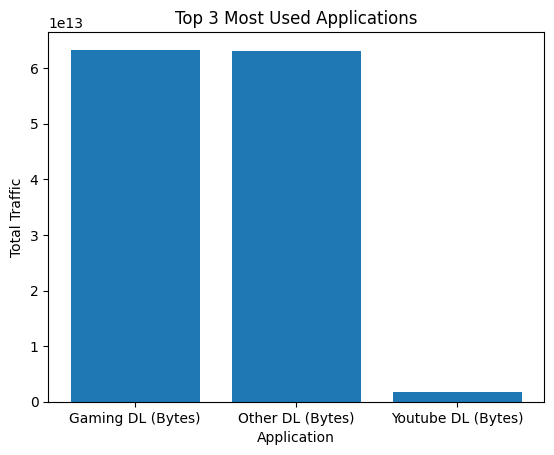

In [94]:
#Plot the top 3 most used applications using appropriate charts. 


# Application columns
application_columns = ['Social Media DL (Bytes)', 'Google DL (Bytes)', 'Email DL (Bytes)',
                       'Youtube DL (Bytes)', 'Netflix DL (Bytes)', 'Gaming DL (Bytes)',
                       'Other DL (Bytes)']

# Calculate total traffic per application
total_traffic = raw_df[application_columns].sum()

# Get the top 3 most used applications
top_3_applications = total_traffic.nlargest(3)

# Plot the top 3 most used applications
plt.bar(top_3_applications.index, top_3_applications.values)
plt.xlabel('Application')
plt.ylabel('Total Traffic')
plt.title('Top 3 Most Used Applications')
plt.show()

C:\Users\dell\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\dell\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\dell\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set th

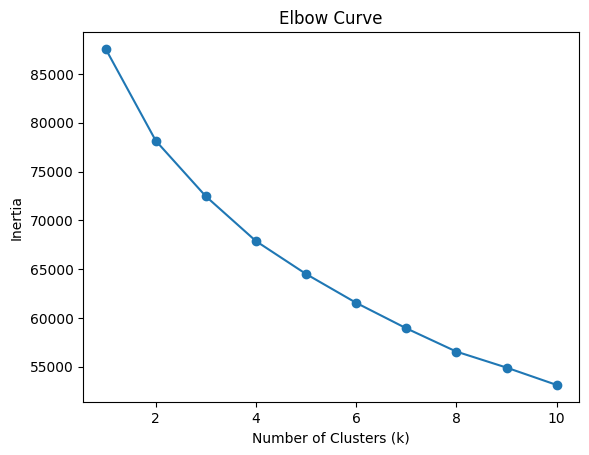

In [95]:
#determine the optimized value of k for grouping users into engagement clusters using the k-means clustering algorithm and the elbow method


# Engagement metrics
engagement_metrics = ['Social Media DL (Bytes)', 'Google DL (Bytes)', 'Email DL (Bytes)',
                      'Youtube DL (Bytes)', 'Netflix DL (Bytes)', 'Gaming DL (Bytes)',
                      'Other DL (Bytes)']

# Select the engagement metrics from the DataFrame
engagement_data = raw_df[engagement_metrics]

# Normalize the engagement data using Min-Max scaling
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(engagement_data)

# Perform k-means clustering for a range of k values
k_values = range(1, 11)  # Try k values from 1 to 10
inertia_values = []  # List to store the inertia (sum of squared distances) for each k value

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(normalized_data)
    inertia_values.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(k_values, inertia_values, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Curve')
plt.show()
